# Weighted Prediction Error

In [1]:
#!pip install soundfile librosa numpy pyroomacoustics matplotlib tqdm

In [2]:
import soundfile as sf
import librosa
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from tqdm import tqdm
import requests
%matplotlib inline

In [3]:
url = "https://drive.usercontent.google.com/download?id=1RarjxOgWkaDV8EjH_eLX169y89PVa3sg&confirm=t"
output = "nonblind_test.clean.zip"

if not Path(output).exists():
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    
    with open(output, 'wb') as file, tqdm(
        desc=output,
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    
    print("Файл успешно скачан:", output)
else:
    print("Файл уже найден")


nonblind_test.clean.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 251M/251M [00:23<00:00, 11.0MB/s]

Файл успешно скачан: nonblind_test.clean.zip


In [4]:
path_reverbed = Path("./reverbed")
path_reverbed.mkdir(exist_ok=True)

path_output_mono = Path("./output_mono")
path_output_mono.mkdir(exist_ok=True)
print("Созданы директории:reverbed, output_mono")

Созданы директории:reverbed, output_mono


In [5]:
current_dir = Path(".")
data = Path("nonblind_test.clean.zip")
with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)
print("Архив успешно разархивирован в clean")

Архив успешно разархивирован в clean


In [6]:
y_clean, sr = sf.read("clean/fileid_1.flac")
print(y_clean.shape, sr)

(336124,) 48000


## Mono

In [7]:
def reverb_audio(y_clean, sr, plot=False):
    room_dim = [6.0, 4.0, 3]
    rt60 = 0.8
    
    absorption, max_order = pra.inverse_sabine(rt60, room_dim)
    
    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )
    
    src_pos = [5.0, 4, 1.7]
    mic_pos = [2.5, 2, 1.6]
    
    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*')
        ax.scatter(mic_pos[0], mic_pos[1], mic_pos[2],
               color='blue', s=200, marker='^')
        plt.title("Виртуальная комната")
        return None

        
    room.add_source(src_pos, signal=y_clean)
    
    mic = pra.MicrophoneArray(np.c_[mic_pos], room.fs)
    room.add_microphone_array(mic)
    
    room.simulate()
    return room.mic_array.signals[0]

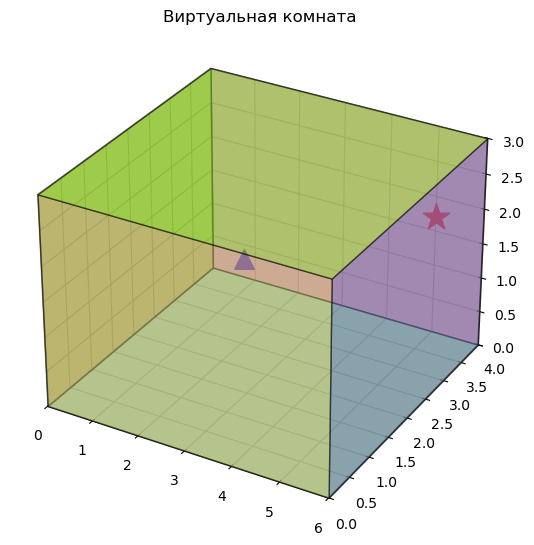

In [8]:
reverb_audio(y_clean, sr, plot=True)

In [9]:
y_reverbed = reverb_audio(y_clean, sr)
sf.write(path_reverbed / "test.flac", y_reverbed, sr)

In [10]:
def plot_audio(y, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Волновая форма")
    plt.xlabel("Время (с)")
    plt.ylabel("Амплитуда")
    plt.tight_layout()
    plt.show

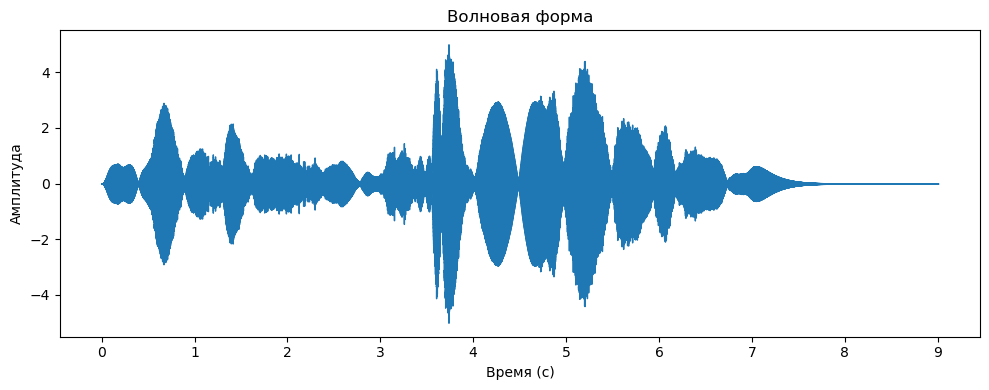

In [11]:
plot_audio(y_reverbed, sr)

In [12]:
def moving_avg_power(x, win_len):
    power = np.abs(x)**2
    w = np.ones(win_len, dtype=float) / max(1, win_len)
    return np.convolve(power, w, mode="same")
    
def wpe_mono(
    y, sr,
    n_fft=512, hop=128, win=512, window="blackman",
    D=3, L=10, N=3, eps=1e-8, reg=1e-6
):

    Y = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win, window=window)
    F, T = Y.shape
    Z = Y.copy()

    t_min = D + L - 1

    for f in range(F):
        yf = Y[f, :]
        if np.allclose(yf, 0):
            continue

        idx = np.arange(t_min, T)
        if idx.size == 0:
            continue

        X = np.vstack([yf[idx - D - l] for l in range(L)])

        lam_full = np.maximum(moving_avg_power(yf, win_len=L), eps)
        lam = lam_full[idx]

        for _ in range(N):

            A = (X.T) / lam[:, None]
            b = (yf[idx]) / lam

            AH = A.conj().T
            R = AH @ A
            R += reg * np.eye(L, dtype=R.dtype)
            p = AH @ b
            g = np.linalg.solve(R, p)

            pred = (X.conj().T @ g)
            z_valid = yf[idx] - pred

            power_all = np.abs(yf)**2
            power_all[idx] = np.abs(z_valid)**2
            lam_full = np.maximum(moving_avg_power(power_all, win_len=L), eps)
            lam = lam_full[idx]

        Z[f, :t_min] = yf[:t_min]
        Z[f, idx] = z_valid

    y_hat = librosa.istft(Z, hop_length=hop, win_length=win, window=window, length=len(y))
    return y_hat

In [13]:
y_wpe = wpe_mono(y_reverbed, sr, D=3, L=10, N=3)

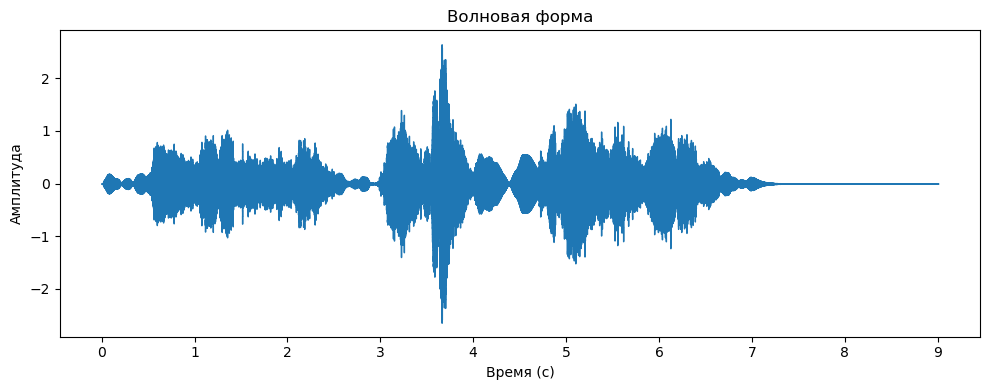

In [14]:
plot_audio(y_wpe, sr)

# Метрики

In [15]:
def fwsegsnr(clean, enhanced, sr, eps=1e-10,
             n_fft=512, hop=128, win=512, window="blackman"):
    X = np.abs(librosa.stft(clean, n_fft=n_fft, hop_length=hop, win_length=win, window=window))
    Xh = np.abs(librosa.stft(enhanced, n_fft=n_fft, hop_length=hop, win_length=win, window=window))

    F, T = X.shape
    fwseg = 0

    for t in range(T):
        w = X[:, t] ** 2
        if np.sum(w) == 0:
            continue
        w /= (np.sum(w) + eps)
        
        num = X[:, t] ** 2
        den = (X[:, t] - Xh[:, t]) ** 2 + eps
        snr_f = np.log10(num / (den + eps))

        fwseg += np.sum(w * snr_f)

    fwseg = 10 * fwseg / (T + eps)
    return fwseg

def cepstral_distance(clean, enhanced, sr, n_mfcc=13):
    clean = clean / np.max(np.abs(clean))
    enhanced = enhanced / np.max(np.abs(enhanced))
    C = librosa.feature.mfcc(y=clean, sr=sr, n_mfcc=n_mfcc)
    Ch = librosa.feature.mfcc(y=enhanced, sr=sr, n_mfcc=n_mfcc)
    T = min(C.shape[1], Ch.shape[1])
    C = C[:, :T]
    Ch = Ch[:, :T]
    diff = (C - Ch) ** 2
    per_frame = np.sqrt(np.sum(diff, axis=0))
    CD = np.mean(per_frame)
    return CD
    

In [16]:
print("Для реверберированного:")
print("FWSegSNR:", fwsegsnr(y_clean, y_reverbed, sr))
print("CD:", cepstral_distance(y_clean, y_reverbed, sr))

print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))

Для реверберированного:
FWSegSNR: -15.606147386618318
CD: 120.51501470187067
Для очищенного
FWSegSNR: -8.438678811408332
CD: 136.45313084896284


In [17]:
y_wpe2 = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)
print("Для L = 15")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe2, sr))
print("CD:", cepstral_distance(y_clean, y_wpe2, sr))

Для L = 15
FWSegSNR: -1.503036476894068
CD: 148.97942223459583


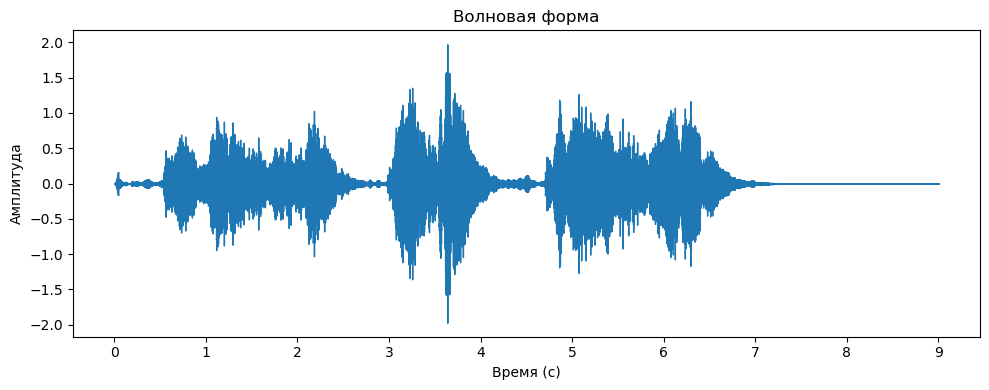

In [18]:
plot_audio(y_wpe2, sr)

In [19]:
sf.write(path_output_mono / "test.flac", y_wpe2, sr)

### Ревербирируем датасет и применяем WPE

In [20]:
test_reverbed = Path(path_reverbed / "test.flac")
if test_reverbed.exists():
    test_reverbed.unlink()

test_wpe = Path(path_output_mono / "test.flac")
if test_wpe.exists():
    test_wpe.unlink()

In [21]:
COUNT_OF_FILES = 50

In [22]:
path_clean = Path("./clean")

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = sf.read(path_clean / file.name)
    y_reverbed = reverb_audio(y_clean, sr)
    y_wpe = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    audio_index += 1

    sf.write(path_reverbed / file.name, y_reverbed, sr)
    sf.write(path_output_mono / file.name, y_wpe, sr)

In [23]:
print("FWSegSNR")
print("Min:", np.min(fwsegsnr_metric))
print("Max:", np.max(fwsegsnr_metric))
print("Mean:", np.mean(fwsegsnr_metric))

FWSegSNR
Min: -8.90126625791516
Max: 6.662360419184848
Mean: -2.630022752732535


In [24]:
print("Cepstral Distance")
print("Min:", np.min(cd_metric))
print("Max:", np.max(cd_metric))
print("Mean:", np.mean(cd_metric))

Cepstral Distance
Min: 60.364090846868336
Max: 148.97942223459583
Mean: 108.5614645011255
